# Exploratory analysis of 4 years of data of physics grades

In [135]:
!python -V #version of python

Python 3.6.5 :: Anaconda, Inc.


In [136]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('precision', 5)
import numpy as np
import re
from scipy import stats
import matplotlib.pyplot as plt

#### Read in .csv and remove blank columns

In [137]:
data = pd.read_csv("grades.csv")
print("physics course grade data read into dataframe successfully")
data.drop(['Unnamed: 8','Unnamed: 9','Unnamed: 10','Unnamed: 11','Unnamed: 12'], axis=1, inplace=True)
data.head()

physics course grade data read into dataframe successfully


,Identifier,Gndr_Flag,Ethnicity,First Gen,PHY 183 term,First day section,Quarter term section,final grade
0,0080B044-2082-44C3-A6A1-A930DE7B456E,F,White (non-Hispanic),Y,FS14,2.0,2.0,1.5
1,008CEDE8-726D-46F8-BEE0-B99200BA8DBD,F,Black or African American (non-Hispanic),N,FS14,1.0,1.0,1.5
2,013133EC-45FB-4627-A436-79E547F5795E,M,International,Y,FS14,1.0,1.0,4.0
3,0131C37C-0336-4A9C-8988-CC605F5EE5A9,M,White (non-Hispanic),N,FS14,2.0,2.0,3.5
4,01A6F74B-7A75-4E4A-B012-9909E17EA743,F,White (non-Hispanic),N,FS14,4.0,4.0,3.5


In [138]:
data.shape

(6345, 8)

In [139]:
data["Ethnicity"].value_counts()

White (non-Hispanic)                             3941
International                                    1193
Asian (non-Hispanic)                              443
Black or African American  (non-Hispanic)         304
Hispanic Ethnicity                                230
Two or more races (non-Hispanic)                  163
Not Reported                                       56
American Indian/Alaskan Native (non-Hispanic)       9
Hawaiian / Pacific Islander (non-Hispanic)          6
Name: Ethnicity, dtype: int64

### Narrow to Domestic Students with reported ethnicity

#### We are interested in looking at the effect of a student's ethnicity on final course grade. We are also interested in only domestic students since this project is aimed at addressing the calls for a more diverse STEM workforce. 

#### 1. Remove all rows that are of students that have Ethnicity values of "International" or "Not Reported"

#### 2. Remove Hawaiian/Pacific Islander & American Indian/Alaskan Native since the N is so tiny

In [140]:
#data = data[data.Ethnicity != 'International']
#data = data[data.Ethnicity != 'Not Reported']

domestic = data.loc[
    (data.Ethnicity != 'International') &
    (data.Ethnicity != 'Not Reported') &
    (data.Ethnicity != 'American Indian/Alaskan Native (non-Hispanic)') &
    (data.Ethnicity != 'Hawaiian / Pacific Islander (non-Hispanic)')
].copy()

In [141]:
domestic["Ethnicity"].value_counts()

White (non-Hispanic)                         3941
Asian (non-Hispanic)                          443
Black or African American  (non-Hispanic)     304
Hispanic Ethnicity                            230
Two or more races (non-Hispanic)              163
Name: Ethnicity, dtype: int64

In [142]:
domestic.shape

(5081, 8)

### Separate students who received numeric grade (completed the course) and those that left the course (Dropped or Withdrawn)

In [143]:
receivedGrade = domestic.loc[
    (domestic["final grade"] != '(dropped)') &
    (domestic["final grade"] != 'W') &
    (domestic["final grade"] != 'V')   
].copy()
leftCourse = domestic.loc[
    (domestic["final grade"] == '(dropped)') |
    (domestic["final grade"] == 'W') 
].copy()

In [144]:
receivedGrade.dtypes
receivedGrade['final grade'] = receivedGrade['final grade'].astype(float)


#### This is the total average grade of everyone who received a grade that is Domestic + Stated Ethnicity

In [145]:
receivedGrade['final grade'].describe()

count    4763.00000
mean        2.99097
std         0.97174
min         0.00000
25%         2.50000
50%         3.00000
75%         3.50000
max         4.00000
Name: final grade, dtype: float64

### Summary of White (non-Hispanic) student grades

In [146]:
receivedGrade.loc[receivedGrade["Ethnicity"] == 'White (non-Hispanic)']["final grade"].describe()

count    3710.00000
mean        3.07507
std         0.91883
min         0.00000
25%         2.50000
50%         3.50000
75%         4.00000
max         4.00000
Name: final grade, dtype: float64

### Summary of Black or African American (non-Hispanic) student grades

In [147]:
receivedGrade.loc[receivedGrade["Ethnicity"] == 'Black or African American  (non-Hispanic)']["final grade"].describe()

count    269.00000
mean       2.25651
std        1.08638
min        0.00000
25%        1.50000
50%        2.50000
75%        3.00000
max        4.00000
Name: final grade, dtype: float64

### Summary of Hispanic student grades

In [148]:
receivedGrade.loc[receivedGrade["Ethnicity"] == 'Hispanic Ethnicity']["final grade"].describe()

count    210.00000
mean       2.55952
std        1.12392
min        0.00000
25%        2.00000
50%        3.00000
75%        3.50000
max        4.00000
Name: final grade, dtype: float64

## Mann-Whitney-Wilcoxon (MWW) RankSum tests

In [149]:
z_stat, p_val = stats.ranksums(
    receivedGrade.loc[receivedGrade["Ethnicity"] == 'White (non-Hispanic)']["final grade"],
    receivedGrade.loc[receivedGrade["Ethnicity"] == 'Black or African American  (non-Hispanic)']["final grade"]
)
receivedGrade.loc[receivedGrade["Ethnicity"] == 'White (non-Hispanic)']["final grade"].mean()
receivedGrade.loc[receivedGrade["Ethnicity"] == 'Black or African American  (non-Hispanic)']["final grade"].mean()

print("Comparing grade distributions of White and Black students p =", format(p_val, '.9f'))


z_stat, p_val = stats.ranksums(
    receivedGrade.loc[receivedGrade["Ethnicity"] == 'White (non-Hispanic)']["final grade"],
    receivedGrade.loc[receivedGrade["Ethnicity"] == 'Asian (non-Hispanic)']["final grade"]
)
print("Comparing grade distributions of White and Asian students p =", format(p_val, '.9f'))


z_stat, p_val = stats.ranksums(
    receivedGrade.loc[receivedGrade["Ethnicity"] == 'White (non-Hispanic)']["final grade"],
    receivedGrade.loc[receivedGrade["Ethnicity"] == 'Hispanic Ethnicity']["final grade"]
)
print("Comparing grade distributions of White and Hispanic students p =", format(p_val, '.9f'))


z_stat, p_val = stats.ranksums(
    receivedGrade.loc[receivedGrade["Ethnicity"] == 'White (non-Hispanic)']["final grade"],
    receivedGrade.loc[receivedGrade["Ethnicity"] == 'Two or more races (non-Hispanic)']["final grade"]
)
print("Comparing grade distributions of White and Multiracial students p =",format(p_val,'.9f'))

Comparing grade distributions of White and Black students p = 0.000000000
Comparing grade distributions of White and Asian students p = 0.018006612
Comparing grade distributions of White and Hispanic students p = 0.000000000
Comparing grade distributions of White and Multiracial students p = 0.167840284


## Histograms of grade distribution by ethnicity

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C4651D3630>,
      dtype=object)

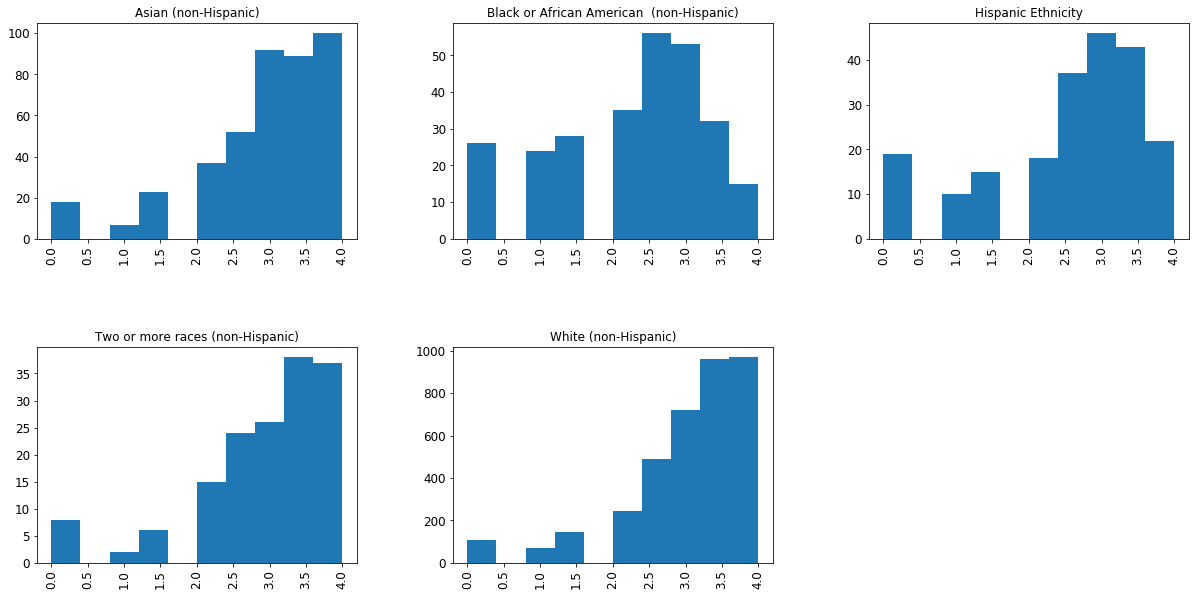

In [177]:
receivedGrade.hist(by='Ethnicity', column='final grade', 
                   figsize=(20,10), xrot=90, xlabelsize=12, 
                   ylabelsize=12, layout=(2,3))